<a href="https://colab.research.google.com/github/IALeMans/RL-meetup-Reinforcement_Learning/blob/master/RL_GridWorld_DQN_dynamique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jeu GRID WORLD - DQN 2

Source https://cdancette.fr/2018/01/03/reinforcement-learning-part3/


## Reinforcement learning en python sur un jeu simple grâce au Q-learning, Partie 3


 Jeu dynamique, le terrain change à chaque partie : utilisation d’un réseau de neurones.
 
 
  le terrain est modifié à chaque partie. Nous n’allons pas pouvoir stocker et visiter tous les états pour entrainer l’agent. Le réseau de neurone apprendra alors a généraliser, pour obtenir une fonction de valeur Q convenable.


> ![Texte alternatif…](https://cdancette.fr/assets/qlearning2/capture.gif) 

Principe :

![Texte alternatif…](https://cdancette.fr/assets/game.png)

## Le jeu 

Une seule différence : nous allons regénérer un terrain à chaque nouvelle partie. 

Ainsi Le seul changement sera la manière d’encoder l’état du jeu.

Ainsi, la fonction get_state sera réécrite de la manière suivante :

    def _get_state(self):
        x, y = self.position
        if self.alea:
            return np.reshape([self._get_grille(x, y) for (x, y) in
                    [self.position, self.end, self.hole, self.block]], (1, 64))
        return flatten(self._get_grille(x, y))

Ici, au lieu de renvoyer un tableau de taille 16 contenant juste la position de notre agent marqué par un 1, nous devons également indiquer la position des éléments sur le terrain.

Les éléments à indiquer sont : 
* notre position **self.position**, 
* la position de l’arrivée **self.end**, 
* la position du trou **self.hole**, 
* et la position du mur **self.block**.

Au lieu d’un tableau de taille 16 contenant des 0, avec un 1 pour marquer la position de l’agent, nous avons maintenant 4 tableaux similaires. L’état du jeu sera la concaténation de ces 4 tableaux (obtenu avec np.reshape). L’état est donc un tableau de taille 4x16 = 64 cases, et il contiendra quatre 1, et les autres éléments seront des 0.

Ici pour encoder les états, nous avons utilisé ce qui est appelé un One Hot encoder : Pour chaque élément, il y a 16 possibilités, et on encode cela en utilisant un tableau de 16 cases, en mettant un 1 pour représenter la position de l’élément, et 0 dans les autres cases. Ce n’est pas une représentation très compacte : les 16 cases possibles peuvent être encodées sur 4 bits, il nous suffirait donc de 4 cases dans notre tableau pour encoder la position de chaque élément. Mais le réseau devrait alors apprendre à décoder cette représentation, ce qui nécessiterait certainement un modèle plus complexe, donc un entrainement plus long, ou bien une architecture plus grosse. L’encodage que nous avons choisi ici est extrèmement simple (mais il n’est pas le plus compact possible, toutes les entrées possibles ne sont pas du tout utilisés), et sera utilisé très facilement par le réseau de neurone.

In [0]:
import random

flatten = lambda l: [item for sublist in l for item in sublist]

class Game:
    ACTION_UP = 0
    ACTION_LEFT = 1
    ACTION_DOWN = 2
    ACTION_RIGHT = 3

    ACTIONS = [ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT, ACTION_UP]

    ACTION_NAMES = ["UP   ", "LEFT ", "DOWN ", "RIGHT"]

    MOVEMENTS = {
        ACTION_UP: (1, 0),
        ACTION_RIGHT: (0, 1),
        ACTION_LEFT: (0, -1),
        ACTION_DOWN: (-1, 0)
    }

    num_actions = len(ACTIONS)

    def __init__(self, n, m, wrong_action_p=0.1, alea=False):
        self.n = n
        self.m = m
        self.wrong_action_p = wrong_action_p
        self.alea = alea
        self.generate_game()

    def _position_to_id(self, x, y):
        """Donne l'identifiant de la position entre 0 et 15"""
        return x + y * self.n

    def _id_to_position(self, id):
        """Réciproque de la fonction précédente"""
        return (id % self.n, id // self.n)

    def generate_game(self):
        cases = [(x, y) for x in range(self.n) for y in range(self.m)]
        hole = random.choice(cases)
        cases.remove(hole)
        start = random.choice(cases)
        cases.remove(start)
        end = random.choice(cases)
        cases.remove(end)
        block = random.choice(cases)
        cases.remove(block)

        self.position = start
        self.end = end
        self.hole = hole
        self.block = block
        self.counter = 0
        
        if not self.alea:
            self.start = start
        return self._get_state()
    
    def reset(self):
        if not self.alea:
            self.position = self.start
            self.counter = 0
            return self._get_state()
        else:
            return self.generate_game()

    def _get_grille(self, x, y):
        grille = [
            [0] * self.n for i in range(self.m)
        ]
        grille[x][y] = 1
        return grille

    def _get_state(self):
        x, y = self.position
        if self.alea:
            return np.reshape([self._get_grille(x, y) for (x, y) in
                    [self.position, self.end, self.hole, self.block]], (1, 64))
        return flatten(self._get_grille(x, y))
    
    def get_random_action(self):
        return random.choice(self.ACTIONS)
    
    def move(self, action):
        """
        takes an action parameter
        :param action : the id of an action
        :return ((state_id, end, hole, block), reward, is_final, actions)
        """

        self.counter += 1

        if action not in self.ACTIONS:
            raise Exception("Invalid action")

        # random actions sometimes (2 times over 10 default)
        choice = random.random()
        if choice < self.wrong_action_p:
            action = (action + 1) % 4
        elif choice < 2 * self.wrong_action_p:
            action = (action - 1) % 4

        d_x, d_y = self.MOVEMENTS[action]
        x, y = self.position
        new_x, new_y = x + d_x, y + d_y

        if self.block == (new_x, new_y):
            return self._get_state(), -1, False, self.ACTIONS
        elif self.hole == (new_x, new_y):
            self.position = new_x, new_y
            return self._get_state(), -10, True, None
        elif self.end == (new_x, new_y):
            self.position = new_x, new_y
            return self._get_state(), 10, True, self.ACTIONS
        elif new_x >= self.n or new_y >= self.m or new_x < 0 or new_y < 0:
            return self._get_state(), -1, False, self.ACTIONS
        elif self.counter > 200:
            self.position = new_x, new_y
            return self._get_state(), -10, True, self.ACTIONS
        else:
            self.position = new_x, new_y
            return self._get_state(), -1, False, self.ACTIONS

    def print(self):
        str = ""
        for i in range(self.n - 1, -1, -1):
            for j in range(self.m):
                if (i, j) == self.position:
                    str += "x"
                elif (i, j) == self.block:
                    str += "¤"
                elif (i, j) == self.hole:
                    str += "o"
                elif (i, j) == self.end:
                    str += "@"
                else:
                    str += "."
            str += "\n"
        print(str)

## Un problème plus complexe

On peut voir que le problème est plus complexe que celui de la partie précédente : 


> au lieu de 4 états différents, encodés dans un tableau de taille 16,

> on a 16x15x14x13 = 43680 états possibles. 



Il serait difficile d’appliquer la méthode de la première partie de ce tutoriel (stocker les Q-values dans un tableau). 

L’utilisation d’un réseau de neurone, comme nous l’avons vu dans la partie 2, nous sera alors très utile ici. 


Avec un réseau légèrement plus complexe, nous allons pouvoir résoudre ce problème. Néanmoins, l’entrainement est plus compliqué ici. Pour garantir la convergence de la méthode classique du Q-learning, l’agent devrait parcourir tous les états un grand nombre de fois. Or ici, notre espace d’état étant très grand, l’agent ne parcourera surement pas la totalité de ces états de nombreuses fois. C’est pour cela que nous attendons de notre réseau de neurone qu’il généralise, pour appliquer ses connaissances acquises à l’entrainement sur des états qu’il n’a jamais rencontré. Il aurait été impossible de généraliser avec la méthode de l’article 1, en utilisant un tableau.

Nous allons évoquer plusieurs concepts très utilisés en machine learning et en reinforcement learning : **le principe du batch**, et celui de **l’experience replay**.

## Batch

En machine learning, pour entrainer nos réseaux de neurones, on utilise généralement des batch de données. 
C’est à dire qu’au lieu de ne donner qu’un seul exemple, avec son label, on lui donne à chaque fois un nombre fixe d’exemples (par exemple 10 samples). Cela permet à l’algorithme de gradient de choisir une direction qui ne dépendra pas que d’un seul exemple, qui pourrait être trop précis et ne pas améliorer le score global, mais plutôt une direction moyenne, qui sera certainement plus bénéfique au réseau de manière générale.

 ![Texte alternatif…](https://cdancette.fr/assets/qlearning3/batches.png)

Le batching est également utilisé quand le dataset entier ne rentre pas dans la RAM / la mémoire du GPU. Il est alors nécéssaire de diviser le dataset en batches, que l’on va charger en mémoire pour entrainer le réseau, puis décharger. La contrainte est alors que la taille d’un batch ne dépasse pas la taille de la mémoire (c’est surtout un problème en traitement d’image, ou les données ont une taille importante).

Le batching est utilisé avec l’algorithme de **stochastig gradient descent** ou descente de gradiant stochastique, en remplaçant un exemple par un petit nombre d’exemples (ou bien avec d’autres algorithmes dérivés tels que Adam).

Le batching est très souvent utilisé en deep learning. Toutefois en reinforcement learning, cela paraît plus compliqué, puisque nous n’avons qu’un exemple à chaque action effectuée. Il est donc impossible à priori d’utiliser cette méthode. Nous allons voir que la méthode de **l’experience replay** permet de résoudre ce problème

## Experience Replay

L’experience replay est une méthode spécifique au reinforcement learning (contrairement au batching qui est utilisé très souvent en deep learning).

Il nous permet en fait d’utiliser des batch pendant l’entrainement de notre agent, au lieu de l’entrainer à chaque mouvement sur les données qu’il vient de recevoir.

Il s’agit de stocker à chaque mouvement les paramètres d’entrainement (état de départ, action, état d’arrivée, récompense, fin du jeu) dans une mémoire, au lieu d’entrainer notre réseau de neurone dessus. Et ensuite, régulièrement, on va piocher un batch dans cette mémoire (c’est à dire un certain nombre d’exemples), au hasard, et on va entrainer notre réseau sur ce batch.

Cela permet d’éviter un trop grand va-et-vient des poids du réseau. En effet, le réseau oublie ce qu’il vient d’apprendre si on lui donne des exemples successifs qui ont des indications contraires (il n’arrive pas à généraliser, et va osciller). En lui donnant un batch en effet, la backpropagation va choisir une direction moyenne pour optimiser les poids du réseau afin de faire diminuer l’erreur.

Cela va également nous permettre de voir plusieurs fois des situations passées. Et les exemples trop vieux seront vidés de la mémoire (on limite la taille de la mémoire en nombre d’exemples).

 ![Texte alternatif…](https://cdancette.fr/assets/qlearning3/experiencereplay.png)

Il existe de nombreuses améliorations possibles. Par exempe, le *Prioritized experience replay (article [1] ou blog), ou on voit les situations les plus importantes en priorité, au lieu tirer des exemples au hasard dans la mémoire.

## Entrainement

In [0]:
# defining the neural network
import numpy as np
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop, Adam, sgd
from keras.layers.advanced_activations import LeakyReLU
import random
import os

from collections import deque

class Trainer:
    def __init__(self, name=None, learning_rate=0.001, epsilon_decay=0.9999, batch_size=30, memory_size=3000):
        self.state_size = 64
        self.action_size = 4
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size
        
        self.name = name
        if name is not None and os.path.isfile("model-" + name):
                model = load_model("model-" + name)
        else:
            model = Sequential()
            model.add(Dense(50, input_dim=self.state_size, activation='relu'))
            model.add(Dense(30, activation='relu'))
            model.add(Dense(30, activation='relu'))
            model.add(Dense(self.action_size, activation='linear'))
            model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        
        self.model = model
        
    def decay_epsilon(self):
        self.epsilon *= self.epsilon_decay
    
    def get_best_action(self, state, rand=True):

        if rand and np.random.rand() <= self.epsilon:
            # The agent acts randomly
            return random.randrange(self.action_size)
        
        # Predict the reward value based on the given state
        act_values = self.model.predict(np.array(state))

        # Pick the action based on the predicted reward
        action =  np.argmax(act_values[0])  
        return action


    def replay(self, batch_size):
        batch_size = min(batch_size, len(self.memory))

        minibatch = random.sample(self.memory, batch_size)

        inputs = np.zeros((batch_size, self.state_size))
        outputs = np.zeros((batch_size, self.action_size))

        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            target = self.model.predict(state)[0]
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.gamma * np.max(self.model.predict(next_state))

            inputs[i] = state
            outputs[i] = target

        return self.model.fit(inputs, outputs, epochs=1, verbose=0, batch_size=batch_size)

    def save(self, id=None, overwrite=False):
        name = 'model'
        if self.name:
            name += '-' + self.name
        else:
            name += '-' + str(time.time())
        if id:
            name += '-' + id
        self.model.save(name, overwrite=overwrite)
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append([state, action, reward, next_state, done])

### Paramètres du trainer


Les paramètres sont assez similaires à ceux de l’article p’écédent. On a juste ajouté une nouvelle couche à notre réseau (pour lui donner une meilleur force de représentation des données).

La ligne qui change est celle-ci :

        self.memory = deque(maxlen=memory_size)

**memory** est la structure de données qui va nous servir de mémoire pour stocker nos ensembles (state, action, new_state, reward). C’est grâce à cette mémoire que l’on peut faire de l’experience replay. A chaque action, on va remplir cette mémoire au lieu d’entrainer, puis on va régulièrement piocher aléatoirement des samples dans cette mémoire, pour lancer l’entrainement sur un batch de données. Pour stocker, on utilise la structure collections.deque de python. Il s’agit d’une queue qui peut avoir une taille limitée, qui va supprimer automatiquement les éléments ajoutés les premiers lorsque la taille limite est atteinte.

### Apprentissage

Nous allons remplacer la fonction train par une fonction remember Au lieu de lancer une étape de backpropagation, elle va tout simplement stocker ce que l’on vient de voir, dans une queue (une structure de données qui va supprimer les éléments entrés en premier).



In [0]:
class Trainer:
    
    ...
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append([state, action, reward, next_state, done])
    



Et enfin, il nous faut une fonction replay qui va piocher dans la mémoire, et donner ces données aux réseau de neurone.

   

In [0]:
...
  def replay(self, batch_size):
        batch_size = min(batch_size, len(self.memory))

        minibatch = random.sample(self.memory, batch_size)

        inputs = np.zeros((batch_size, self.state_size))
        outputs = np.zeros((batch_size, self.action_size))

        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            target = self.model.predict(state)[0]
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.gamma * np.max(self.model.predict(next_state))

            inputs[i] = state
            outputs[i] = target



Ainsi, ici, on va utiliser random.sample pour piocher un certain nombres d’éléments aléatoirement dans la mémoire. On crée alors nos entrées et sorties dans le bon format pour le réseau de neurone, similairement à la fonction train de l’article précédent. La différence est qu’ici, on crée un batch de plusieurs samples, au lieu de n’en donner qu’un (on voit que la dimension des input et output est (batch_size, state_size), alors qu’elle n’avait qu’une dimension précedemment.

## Lancer l’entrainement

La fonction d’entrainement est un peu plus complexe, puisqu’on va executer une première partie ou l’on va remplir en partie la mémoire. Cela nous permettra de pouvoir créer des batch avec assez de données plus rapidement. Cette phase se déroule entre les lignes 13 et 25 du code ci-dessous.

La deuxième phase est l’entrainement du réseau. On lance un entrainement à chaque 100 mouvements. On pourrait essayer d’en lancer plus ou moins souvent, l’apprentissage en serait surement impacté au niveau rapidité de convergence et qualité du minimum local. En général, lorsqu’un algorithme converge trop vite, le minimum local sera moins bon.

In [0]:
import time 
from IPython.core.debugger import set_trace

def train(episodes, trainer, wrong_action_p, alea, collecting=False, snapshot=5000):
    batch_size = 32
    g = Game(4, 4, wrong_action_p, alea=alea)
    counter = 1
    scores = []
    global_counter = 0
    losses = [0]
    epsilons = []

    # we start with a sequence to collect information, without learning
    if collecting:
        collecting_steps = 10000
        print("Collecting game without learning")
        steps = 0
        while steps < collecting_steps:
            state = g.reset()
            done = False
            while not done:
                steps += 1
                action = g.get_random_action()
                next_state, reward, done, _ = g.move(action)
                trainer.remember(state, action, reward, next_state, done)
                state = next_state

    print("Starting training")  
    global_counter = 0
    for e in range(episodes+1):
        state = g.generate_game()
        state = np.reshape(state, [1, 64])
        score = 0
        done = False
        steps = 0
        while not done:
            steps += 1
            global_counter += 1
            action = trainer.get_best_action(state)
            trainer.decay_epsilon()
            next_state, reward, done, _ = g.move(action)
            next_state = np.reshape(next_state, [1, 64])
            score += reward
            trainer.remember(state, action, reward, next_state, done)
            state = next_state
            if global_counter % 100 == 0:
                l = trainer.replay(batch_size)
                losses.append(l.history['loss'][0])
            if done:
                scores.append(score)
                epsilons.append(trainer.epsilon)
            if steps > 200:
                break
        if e % 200 == 0:
            print("episode: {}/{}, moves: {}, score: {}, epsilon: {}, loss: {}"
                  .format(e, episodes, steps, score, trainer.epsilon, losses[-1]))
        if e > 0 and e % snapshot == 0:
            trainer.save(id='iteration-%s' % e)
    return scores, losses, epsilons

On peut alors lancer l’entrainement

In [0]:
trainer = Trainer(learning_rate=0.001, epsilon_decay=0.999995)
scores, losses, epsilons = train(35000, trainer, 0.1, True, snapshot=2500)

Starting training
episode: 0/35000, moves: 16, score: -25, epsilon: 0.9999200029999294, loss: 0
episode: 200/35000, moves: 13, score: -22, epsilon: 0.9814001063725329, loss: 1.7394689321517944
episode: 400/35000, moves: 7, score: 4, epsilon: 0.9648862218983311, loss: 2.8518009185791016
episode: 600/35000, moves: 11, score: -20, epsilon: 0.9473988189758515, loss: 1.1752405166625977
episode: 800/35000, moves: 18, score: -7, epsilon: 0.9318204094956437, loss: 2.499586820602417
episode: 1000/35000, moves: 2, score: -11, epsilon: 0.9167181477463254, loss: 3.792001485824585
episode: 1200/35000, moves: 18, score: -27, epsilon: 0.9001982493573206, loss: 2.2735531330108643
episode: 1400/35000, moves: 15, score: -4, epsilon: 0.8835341723717306, loss: 0.05706949904561043
episode: 1600/35000, moves: 35, score: -44, epsilon: 0.8696361708712141, loss: 3.0634708404541016
episode: 1800/35000, moves: 37, score: -46, epsilon: 0.8517089646646874, loss: 5.344153881072998
episode: 2000/35000, moves: 7, sco

Puis affichons les courbes de loss

<Figure size 432x288 with 0 Axes>

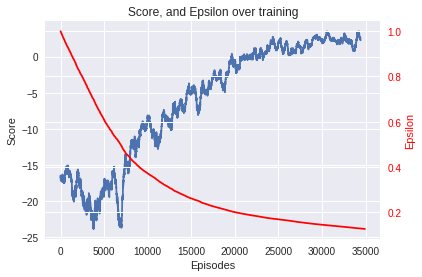

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def smooth(vector, width=30):
    return np.convolve(vector, [1/width]*width, mode='valid')
  
  
sc = smooth(scores, width=500)


fig, ax1 = plt.subplots()
ax1.plot(sc)
ax2 = ax1.twinx()
ax2.plot(epsilons, color='r')
ax1.set_ylabel('Score')
ax2.set_ylabel('Epsilon', color='r')
ax2.tick_params('y', colors='r')
plt.title("Score, and Epsilon over training")
ax1.set_xlabel("Episodes")
plt.figure()

On voit très clairement que notre réseau a appris à jouer de manière satisfaisante. Le score moyen en fin d’apprentissage est légèrement au dessus de 0, ce qui veut dire que l’agent arrive à la fin en moyenne en moins de 10 coups.

In [0]:


from IPython import display
import time
g = Game(4, 4, 0.1, alea=True)



In [0]:
state = g.reset()
state = g._get_state()
print("state")
print("  ")
g.print()
done = False
time.sleep(5)
while not done:
    time.sleep(1)
    display.clear_output(wait=True)
    print(trainer.model.predict(np.array(g._get_state())))
    action = trainer.get_best_action(g._get_state(), rand=False)
    print(Game.ACTION_NAMES[action])
    next_state, reward, done, _ = g.move(action)
    g.print()
print(reward)

[[3.7476544 5.4571967 6.7407804 6.145734 ]]
DOWN 
....
....
o.¤.
...x

10
